In [1]:
#import neccessary packages
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display
pd.set_option('display.max_columns', None,'display.max_rows', None)
import pyutilib.services
from importlib import reload
import matplotlib.pyplot as plt
import numpy as np
import os

os.makedirs('Saved_solutions',exist_ok=True)
os.makedirs('Saved_models',exist_ok=True)

Module_path = 'Modules'  # specify path to modules folder where baf, fopt, and are located, 
                            # change as needed for environment
import sys
sys.path.insert(0,Module_path)
import base_functions as baf
import Bolt_opt_functions as fopt
import analysis_functions as anf
import multiprocessing

# Model Inspection

Models can be inspected independent of the optimization prcedure:

In [2]:
RTModel = 'RhodosporidiumToruloides.pkl'
lowKModel='smallModel_lowK.pkl'
highKModel='smallModel_highK.pkl'
baseModel='Fungal-metabolic-model-250rxns-sucrose-lowNADP2NADPH.pkl'
arabitolModel='Fungal-metabolic-model-250rxns-sucrose-lowNADP2NADPH-Arabitol.pkl'
fungalModel = 'Fungal-metabolic-model-250rxns-sucrose-lowNADP2NADPH-Arabitol-Xylose.pkl'
model_inspection = arabitolModel

In [3]:
S_active, active_reactions, metabolites, Keq = baf.load_model('Saved_models/'+highKModel)

In [4]:
display(active_reactions)
display(metabolites)
display(S_active)

,LEFT,RIGHT,LEFT_COMPARTMENT,RIGHT_COMPARTMENT,DGZERO,Same Compartment?,Full Rxn,KQ,Obj_Coefs,Flux_Direction,Allow_Regulation,Environment_direction
R1,x1:CYTOSOL,x2:CYTOSOL + x3:CYTOSOL,CYTOSOL,CYTOSOL,13.6,True,x1:CYTOSOL = x2:CYTOSOL + x3:CYTOSOL,0.00414,0,0,1,0
R2,x3:CYTOSOL,x2:CYTOSOL,CYTOSOL,CYTOSOL,9.0,True,x3:CYTOSOL = x2:CYTOSOL,0.02650,0,0,1,0
R3,x2:CYTOSOL,x4:CYTOSOL,CYTOSOL,CYTOSOL,9.0,True,x2:CYTOSOL = x4:CYTOSOL,0.02650,0,0,1,0
Uptake,x1_e:ENVIRONMENT,x1:CYTOSOL,ENVIRONMENT,CYTOSOL,-4.4,False,x1_e:ENVIRONMENT = x1:CYTOSOL,5.89990,0,0,1,-1
Excretion,x4:CYTOSOL,x4_e:ENVIRONMENT,CYTOSOL,ENVIRONMENT,3.8,False,x4:CYTOSOL = x4_e:ENVIRONMENT,0.21600,0,0,1,1
Biomass,x3:CYTOSOL,B:CYTOSOL,CYTOSOL,CYTOSOL,3.8,True,x3:CYTOSOL = B:CYTOSOL,0.21600,1,0,1,0


,Conc,Variable,Target Conc,dn/dt,Steady_State,Net_Flux,Lower_Bound,Upper_Bound
x1:CYTOSOL,1.000000e-04,True,0.0010,0.0,Explicit,0.0,1.000000e-120,0.001
x2:CYTOSOL,1.000000e-04,True,0.0010,0.0,Explicit,0.0,1.000000e-120,0.001
x3:CYTOSOL,1.000000e-04,True,0.0010,0.0,Explicit,0.0,1.000000e-120,0.001
x4:CYTOSOL,1.000000e-04,True,0.0010,0.0,Explicit,0.0,1.000000e-120,0.001
x1_e:ENVIRONMENT,1.000000e-04,False,0.0001,0.0,Implicit,0.0,1.000000e-120,0.001
x4_e:ENVIRONMENT,1.000000e-04,False,0.0001,0.0,Implicit,0.0,1.000000e-120,0.001
B:CYTOSOL,1.000000e-15,False,0.0001,0.0,Implicit,0.0,1.000000e-120,0.001


,x1:CYTOSOL,x2:CYTOSOL,x3:CYTOSOL,x4:CYTOSOL,x1_e:ENVIRONMENT,x4_e:ENVIRONMENT,B:CYTOSOL
R1,-1,1,1,0,0,0,0
R2,0,1,-1,0,0,0,0
R3,0,-1,0,1,0,0,0
Uptake,1,0,0,0,-1,0,0
Excretion,0,0,0,-1,0,1,0
Biomass,0,0,-1,0,0,0,1


# Compose base simulation

Options can be selected to impose changes on how the metabolites behave in the optimization. The metabolites in the model are set to be variable and an optimal cocnentration will be found or fixed and the concentration will remain constant throughout the simulation.

- $\textbf{'remove_metabolites'}$ : metabolites to remove from the model.

- $\textbf{'initial_conditions'}$ : the initial concentration values for metabolites in the model. 

- $\textbf{'boundary_conditions'}$ : the boundary conditions for the fixed metabolites used for product metabolties ued in biomass objective functions and metabolite fixed to the envionment condition values. 


The concentrations of metabolites in the system are required to be in steady state for the optimization to be sucessful. Whether or not the metabolite concentration is included in the determination of the model steady state can be changed.

- $\textbf{'implicit_metabolites'}$ : whether to calculate the steady state of the metabolite but not include the metabolite in the system steady state calculation.

- $\textbf{'explicit_metabolites'}$ : whether to calculate the steady state for the metabolite and include the metabolite in the system steady state calculation. Fixed metabolites are required to have their steady states explicitly included in the system calculation.



The metabolite concentration values of the variable metabolites are optimised to be within an upper and lower bound. 

- $\textbf{'raise_bounds'}$ : a list of names for metabolites whose upper concentration bound is to be raised to a maximum to remove any constriction on the upper concentration.  

- $\textbf{'specify_upper_bound'}$ : the upper bound on the variable metabolite concentrations in the model can be set to constrain the solution.

- $\textbf{'specify_lower_bound'}$ : the lower bound on the variable metabolite concentrations in the model can be set to constrain the solution.



Metabolites are in ggeneral both produced or consumed through different reactions in the metabolism. However, throughouth the whol emetabolism a metabolite will either be produced or consumed as the net flux of a metabolite will be the sum of the individual reaction fluxes that the metabolite is involved in. 

- $\textbf{'net_flux'}$ : if the direction for the net flux for a particular metabolite it known (i.e the metabolite is known to be produced or consumed). The metabolite is associated with a value +1 for overall production, -1 for overall consumption, and 0 for no setting.

A subset of the metabolites in the model may be designated as redox metabolites if they are involved in reduction-oxidation reactions. These metabolites occur in pairs (the reduced and the oxidised forms) and are often described as having relative concentrations fixed as a ratio. This ratio value depends on the cell species and the state of the cell. Therefore scanning over a range of ratio values can be used to investigate different cell states. 

- $\textbf{'redox_pairs'}$ : given a pair of metabolites names, if both species are variable then fix the metabolite to the input concentration value. The second metabolite renames variable. If one of the pair or both species are fixed then do nothing. 
- $\textbf{'redox_ratios'}$ : given a pair of metabolites fix the concentratio ratio between them. Both species are fixed with the initial concentration of the first metabolite set to ratio*second metabolite.


Reactions in the model can be altered to incorporate more information into the optimization process. 


- $\textbf{'remove_reactions'}$ : reactions to remove from the model.

- $\textbf{'flux_direction'}$ : if the direction of the optimized flux is known a priori then the direction can be fixed. The direction can be set to -1, 0, 1, for reverse, no setting, and forward respectively. 

- $\textbf{'allow_regulation'}$ : if a reaction is known to be unregulated then the regulation can be removed. The regulation can be set to 1 for including the regulation or 0 for removing all regulaiton of the reaction. 

The optimizing problem requires a list of objective reactions that are included within the model. The metabolite concentrations, regulation, and reaction fluxes will be chosen in order to maximise the flux through the objective reactions. The importance weighting between members of a set of objective reactions is given through the 'obj_coefs' as the flux through a higher coefficient reaction will be given greater improtance in the overall model objective value. A secondary objective can be provided where the flux through the secondary objective reactions will be maximised while remaining within a tolerance of the maximised primary objective value. For the secondary objective to be optimized the primary objective must have origionally converged sucessfully. 

- $\textbf{'obj_coefs'}$ : if the input model does not contain the objective coefficients (in the metabolites dataframe) then provide them here. This will override the model coefficients.

- $\textbf{'secondary_objective'}$ : use a supplied list of secondary objective coefficients, not the ones in the dataframe as for the primary objective. The secondary objective 

- $\textbf{'primary_obj_tolerance'}$ : bound for loss in objective value while maximising the flux through secondary pathways. np.sum(y_ini*primary_obj_coefs) - primary_obj_tolerance


To switch off an experiment option the user can remove the entry from the simulation dictionary. In the event that the option is required for the optimization to proceed then a default parameter will be used. 

In [5]:
base_simulation_list=[]
simulation_test={
    'name':'smallModel',
    'model':'smallModel_highK.pkl',
    'model_output':'output_smallModel_',
#     'secondary_objective': {'protein_syn':1, 'rna_syn':1,'dna_syn':1}, # dictionary 'reaction name': val where val \in reals
#     'primary_obj_tolerance': 100, # positive real, default 100
    'initial_conditions':{}, # dictionary'metabolite name': val where val \in positive reals
    'boundary_conditions':{}, # dictionary'metabolite name': val where val \in positive reals
#     'obj_coefs':{}, # dictionary'reaction name': val where val \in reals; if this is defined 
#     'remove_metabolites':['SUCROSE:ENVIRONMENT'], # list'metabolite name'
#     'remove_reactions':['RXN-1461'], # list 'reaction name'
    'implicit_metabolites':[], # list 'metabolite name', default for Fixed species
    'explicit_metabolites':[], # list 'metabolite name', default for Variable species
#     'redox_pairs':[
#        ['NADPH:CYTOSOL' ,'NADP+:CYTOSOL'],
#        ['A REDUCED THIOREDOXIN:CYTOSOL', 'AN OXIDIZED THIOREDOXIN:CYTOSOL'],
#        ['UBIQUINOL:MITOCHONDRIAL_MEM','UBIQUINONE:MITOCHONDRIAL_MEM'],
#         ['OXYGEN:CYTOSOL' ,'GMP:CYTOSOL']
#     ], # list of pairs of metabolite names [[a,b],[c,d]] if both variable then fix first name (i.e a and c)
#     'redox_ratios':[{'names':['NADH:CYTOSOL','NAD+:CYTOSOL'],'ratio':1.2},
#                    {'names':['NADH:MITOCHONDRIA','NAD+:MITOCHONDRIA'],'ratio':1.2}], # list of dictionaries containing a list of pair of metabolites and the ratio
#     'raise_bounds':['PROTEIN','RNA','DNA'],
#     'specify_upper_bound':{'ALPHA-D-GLUCOSE:CYTOSOL':1e-3}, # default 1e-3
#     'specify_lower_bound':{'ALPHA-D-GLUCOSE:CYTOSOL':1e-120}, # default 1e-120
    'net_flux':{}, # dictionary 'metabolite name': val where val \in {1, 0, -1}, default 0 
    'flux_direction':{}, # dictionary 'reaction_name': val where val \in {1, 0, -1}, default 0 
    'allow_regulation':{} # dictionary 'reaction_name': val where val \in {1, 0}, default 1 
}
base_simulation_list.append(simulation_test)

# Set optimization configuration conditions

In addition to the different simulation experiments for the optimization process, a set of control parameters are required to be passed to the optimization suite. These control parameters alter how the swarm hyperparameter behaves and sets the solver conditions.   

- $\textbf{'model_file_dir'}$ : string directory name for the model input files
- $\textbf{'solution_file_dir'}$ : string directory name in which to save the simulation solution files
- $\textbf{'parallel_solve'}$ : boolean switch for whether to use parallel pool for solving multiple optimization problems in paralllel on the CPU. (default True)
- $\textbf{'worker_count'}$ : the number of parallel pool workers distributed over the CPU cores. The value is only used if 'parallel_solve' is True.

- $\textbf{'deltaConcentration'}$ : double or list of doubles for the perturbation strength of 
    initial concentrations about the model input for each swarm agents (default 0)
- $\textbf{'deltaFlux'}$ : double or list of doubles for the perturbation strength of 
    initial flux values about the model input for each swarm agents (default 0)
- $\textbf{'mb'}$ : the relaxation hyperparameter for the optimization constraints (default 100)
- $\textbf{'zeta'}$ : scaling parameter for the initial flux values before the optimization solve (default 0.1)
- $\textbf{'swarm_size'}$ : number of agents within a swarm (default: 2) 
- $\textbf{'linear_solver'}$ : a string for a specific desired solver name (default ma27)
- $\textbf{'max_cpu_time'}$ : the maximum number of cpu seconds for a single solve attempt after which the solve has considered to have stalled (default: 800000)
- $\textbf{'max_iter'}$ : the maximum number of solver iterations before terminating with a failed convergence (default: 10000)
- $\textbf{'acceptable_tol'}$ : acceptable convergence tolerance within which a non-converged solution can be considered accurate enough (default: 1e-6)
- $\textbf{'solver_tol'}$ : convergence tolerance within which an optimization is considered converged (default: 1e-7)
- $\textbf{'feasibility_check'}$ : use the initial feasiblity tests with a zero null objective function, a converged simulation can be used to infer feasibility fo the model
- $\textbf{'feasibility_as_input'}$ : use the output solution from the null objective test as the initial point for solving the non-null objective
- $\textbf{'annealing_check'}$ : initialise the eimulation optimization solve using simulated annealing to find a candidate initial condition. 
- $\textbf{'hsllib'}$ : a string file path for the .dylib file of the Haswell Subroutine Library. This option should be set if required for the specific IPOPT solver routine if using the HSL solvers and the environment variable is not already set.
    
For the list of control configurations ('delta_concentration', 'delta_flux', 'mb', 'zeta') the simulation experiment set will be duplicated for each value pair in order to provide hyperparameter scanning capabilities. 

In [10]:
control_dictionary={
    'model_file_dir':'Saved_models', # default 'Saved_models'
    'solution_file_dir':'Saved_solutions', # default 'Saved_solutions'
    'parallel_solve':False,# boolean True/False
    'worker_count': 1,  # natural number, 0 or remove for cpu_count
    'delta_concentration':[0], # list positive reals
    'delta_flux':[0], # list positive reals
    'mb':[100], # list positive naturals
    'zeta':[0.01], # list positive reals
    'swarm_size':5, # naturals, default is 2
    'linear_solver': 'ma57',
    'max_cpu_time':800000,
    'max_iter':100000,
    'acceptable_tol':1e-6,
    'solver_tol':1e-7,
    'feasibility_check':False,
    'feasibility_as_input':False,
    'annealing_check':False
#     'hsllib':'/opt/coinhsl/lib/libcoinhsl.dylib'
}

# Form simulation experiments

Different experiments may be performed by scanning over changes in simulation configurations. The scans duplicate the set of base simulation for each scanned condition. Impose experiment scans options:



- $\textbf{ScanOverInitialCondition(simulation_list,chemical_name,value_list)}$ : prove a chemical name from the model and set the initial concentration of the chemical to each value in a list. 

- $\textbf{ScanOverBoundaryCondition(simulation_list,chemical_name,value_list)}$ : prove a chemical name from the model and set the fixed boundary concentration of the chemical to each value in a list.  

- $\textbf{ScanOverRedoxRatios(simulation_list,redox_pair_list, ratio_list)}$ :  prove a list containg a pair of chemical names which are memebers of a redox pair couple. The ratio between the two concentrations is set from ratio values in a provided list. 


In [11]:

simulationList = base_simulation_list

# change gluc:fruc ratios
metabolite_name = 'B:CYTOSOL'

conditions=[1e-15,1e-14,1e-13,1e-12,1e-11,1e-10,1e-9,1e-8,1e-7,1e-6,1e-5,1e-4,1e-3]

simulationList = baf.ScanOverInitialCondition(simulationList,metabolite_name,conditions)
# redox_ratios=[1,0.5,0.25,0.1]
# simulationList = baf.ScanOverRedoxRatios(simulationList,['A REDUCED THIOREDOXIN:CYTOSOL', 'AN OXIDIZED THIOREDOXIN:CYTOSOL'],redox_ratios)


# Run the actual optimization swarm

In [12]:

print()
print("Solving "+str(len(base_simulation_list))+" base simulations.")
print("Solving "+str(len(simulationList))+" total simulations.")
        
bestSimulations = baf.RunSwarmSimulation(simulationList,control_dictionary)
display(bestSimulations)


Solving 1 base simulations.
Solving 13 total simulations.
Sim Name: smallModel_B:CYTOSOL_1e-15_swarm_0_100_0.01_0_0 objective: 3918.903519159961 status: ok
Sim Name: smallModel_B:CYTOSOL_1e-15_swarm_1_100_0.01_0_0 objective: 3918.903519159961 status: ok
Sim Name: smallModel_B:CYTOSOL_1e-15_swarm_2_100_0.01_0_0 objective: 3918.903519159961 status: ok
Sim Name: smallModel_B:CYTOSOL_1e-15_swarm_3_100_0.01_0_0 objective: 3918.903519159961 status: ok
Sim Name: smallModel_B:CYTOSOL_1e-15_swarm_4_100_0.01_0_0 objective: 3918.903519159961 status: ok
Sim Name: smallModel_B:CYTOSOL_1e-14_swarm_0_100_0.01_0_0 objective: 2059.6368494737917 status: ok
Sim Name: smallModel_B:CYTOSOL_1e-14_swarm_1_100_0.01_0_0 objective: 2059.6368494737917 status: ok
Sim Name: smallModel_B:CYTOSOL_1e-14_swarm_2_100_0.01_0_0 objective: 2059.6368494737917 status: ok
Sim Name: smallModel_B:CYTOSOL_1e-14_swarm_3_100_0.01_0_0 objective: 2059.6368494737917 status: ok
Sim Name: smallModel_B:CYTOSOL_1e-14_swarm_4_100_0.01_0

Sim Name: smallModel_B:CYTOSOL_1e-06_swarm_3_100_0.01_0_0 objective: 19.37376984992282 status: ok
Sim Name: smallModel_B:CYTOSOL_1e-06_swarm_4_100_0.01_0_0 objective: 19.37376984992282 status: ok
Sim Name: smallModel_B:CYTOSOL_1e-05_swarm_0_100_0.01_0_0 objective: -4.4593087205728334e-08 status: ok
Sim Name: smallModel_B:CYTOSOL_1e-05_swarm_1_100_0.01_0_0 objective: -4.4593087205728334e-08 status: ok
Sim Name: smallModel_B:CYTOSOL_1e-05_swarm_2_100_0.01_0_0 objective: -4.4593087205728334e-08 status: ok
Sim Name: smallModel_B:CYTOSOL_1e-05_swarm_3_100_0.01_0_0 objective: -4.4593087205728334e-08 status: ok
Sim Name: smallModel_B:CYTOSOL_1e-05_swarm_4_100_0.01_0_0 objective: -4.4593087205728334e-08 status: ok
Sim Name: smallModel_B:CYTOSOL_0.0001_swarm_0_100_0.01_0_0 objective: -7.979703380648119e-09 status: ok
Sim Name: smallModel_B:CYTOSOL_0.0001_swarm_1_100_0.01_0_0 objective: -7.979703380648119e-09 status: ok
Sim Name: smallModel_B:CYTOSOL_0.0001_swarm_2_100_0.01_0_0 objective: -7.979

[{'Mb': 100,
  'zeta': 0.01,
  'delta_concentration': 0,
  'delta_flux': 0,
  'bestSimulations': {'smallModel_B:CYTOSOL_1e-15_': {'swarm_instance_name': 'smallModel_B:CYTOSOL_1e-15_swarm_0_100_0.01_0_0',
    'swarm_instance_value': 3918.903519159961,
    'swarm_secondary_value': 0,
    'average_objective': 3918.9035191599605,
    'average_secondary_objective': 0.0,
    'number_of_converged_simulations': 5,
    'converged_simulation_list': ['smallModel_B:CYTOSOL_1e-15_swarm_0_100_0.01_0_0',
     'smallModel_B:CYTOSOL_1e-15_swarm_1_100_0.01_0_0',
     'smallModel_B:CYTOSOL_1e-15_swarm_2_100_0.01_0_0',
     'smallModel_B:CYTOSOL_1e-15_swarm_3_100_0.01_0_0',
     'smallModel_B:CYTOSOL_1e-15_swarm_4_100_0.01_0_0'],
    'converged_simulation_objectives': [3918.903519159961,
     3918.903519159961,
     3918.903519159961,
     3918.903519159961,
     3918.903519159961],
    'converged_simulation_secondary_objectives': [0, 0, 0, 0, 0]},
   'smallModel_B:CYTOSOL_1e-14_': {'swarm_instance_name':

# Analyse model output

smallModel_B:CYTOSOL_1e-15_


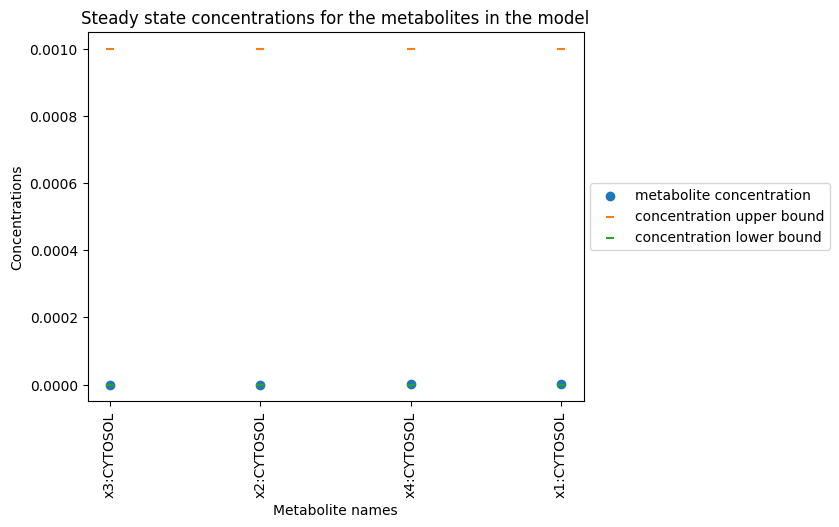

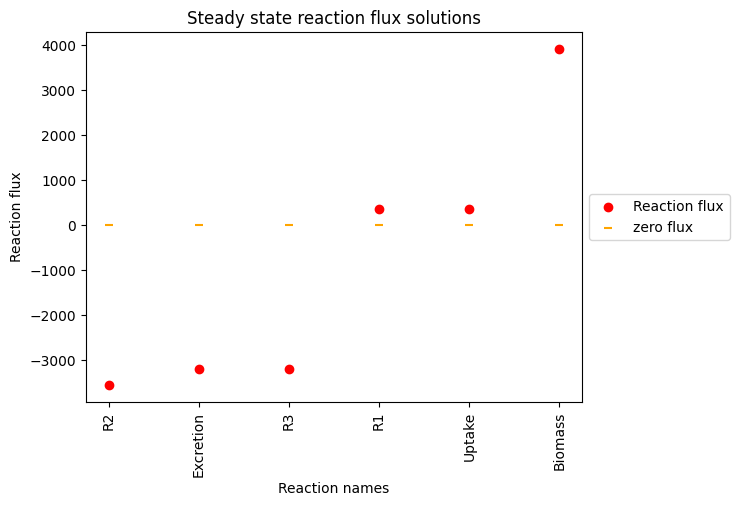

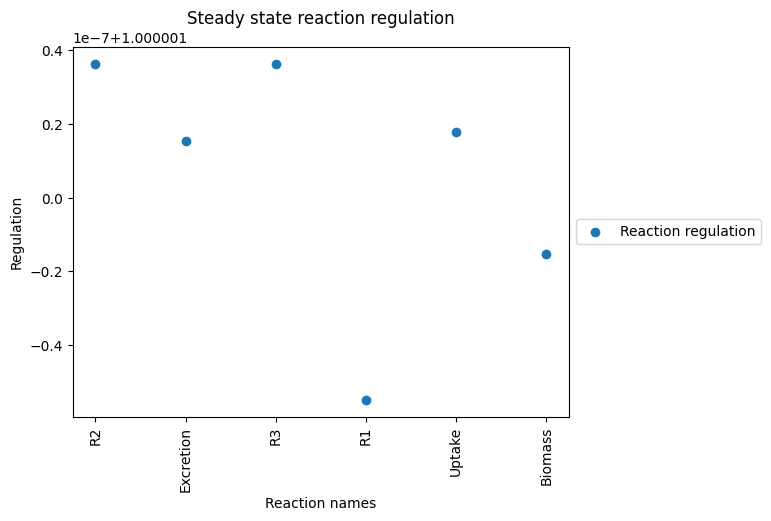

smallModel_B:CYTOSOL_1e-14_


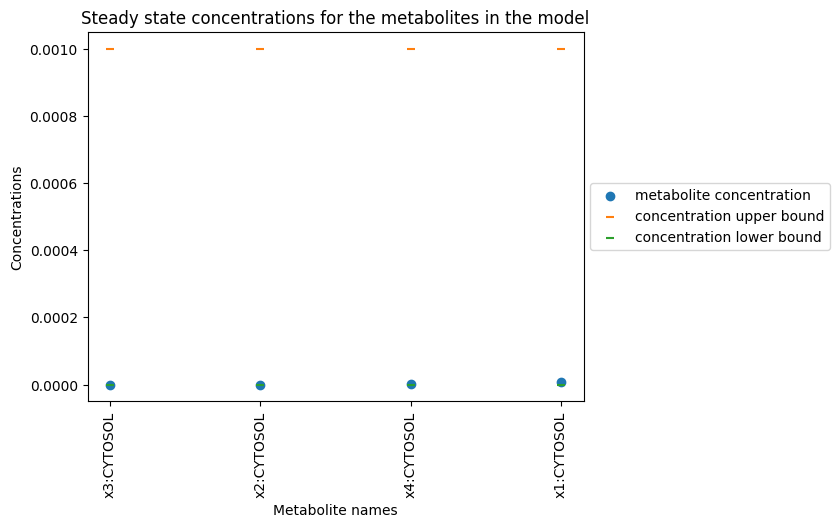

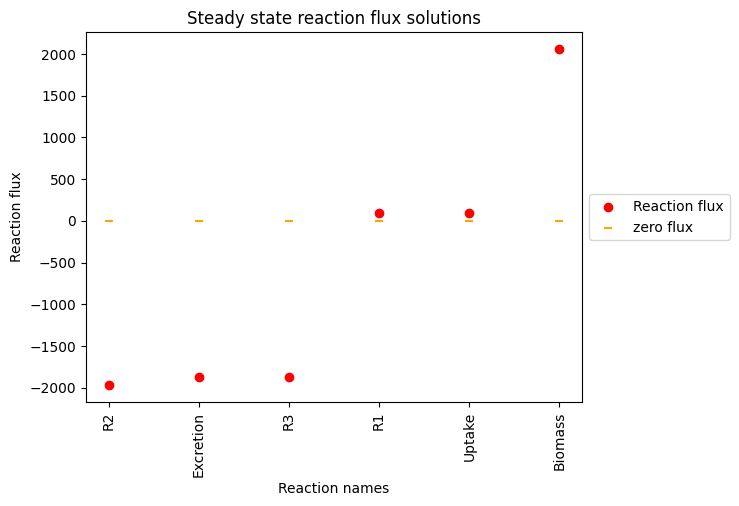

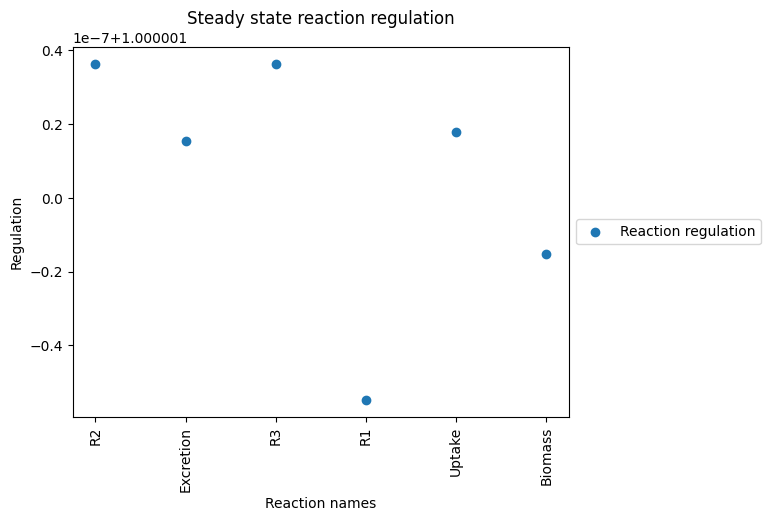

smallModel_B:CYTOSOL_1e-13_


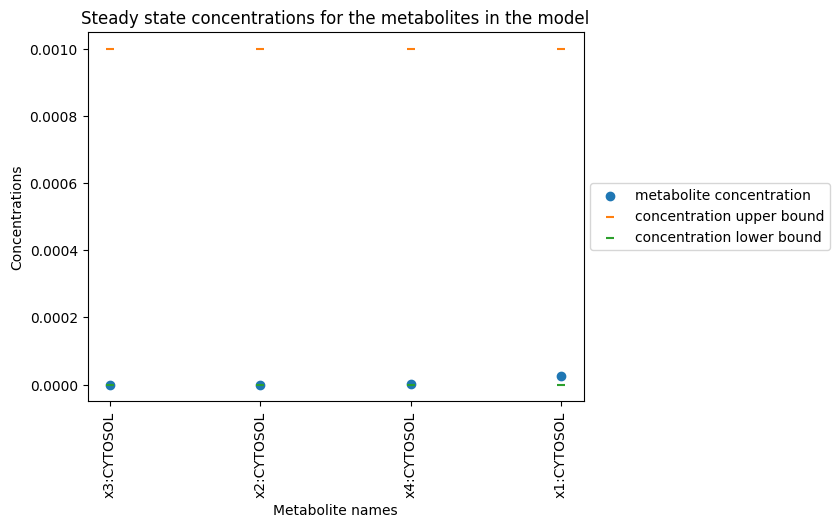

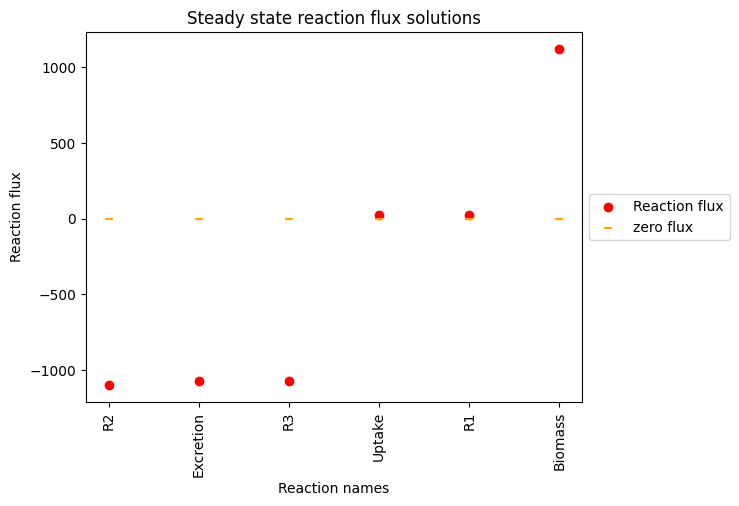

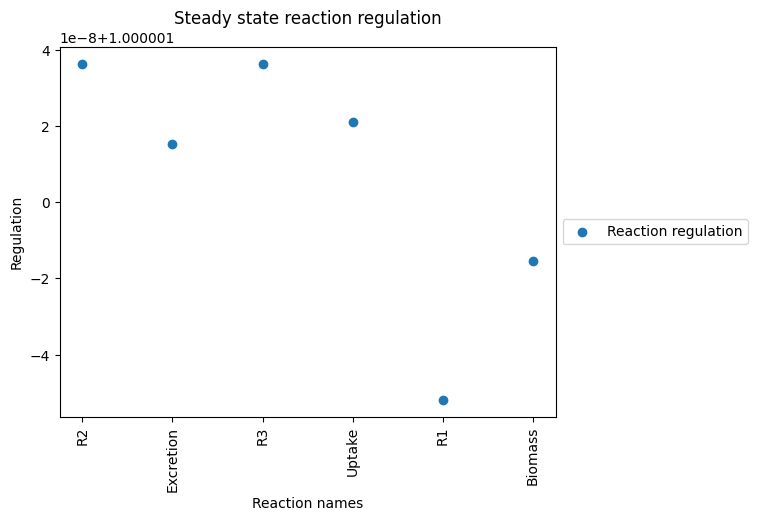

smallModel_B:CYTOSOL_1e-12_


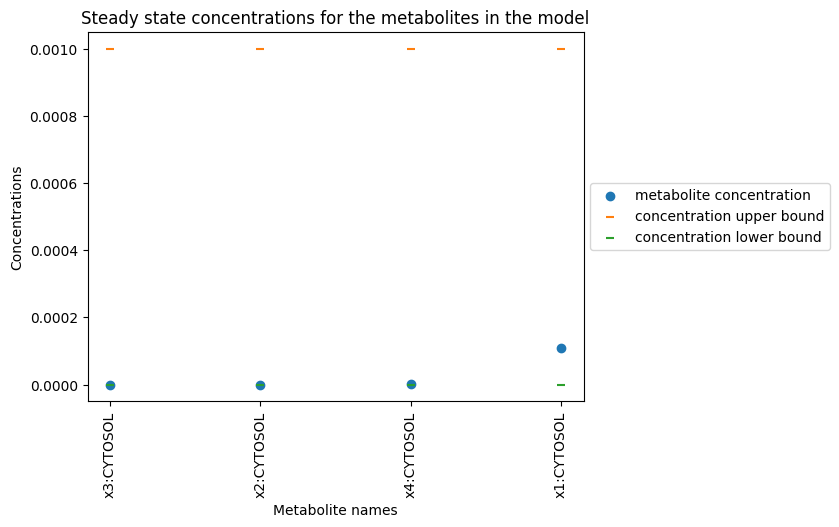

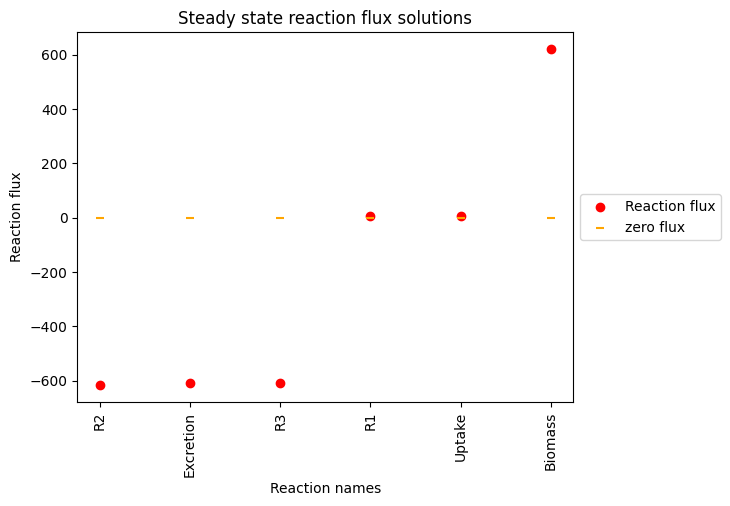

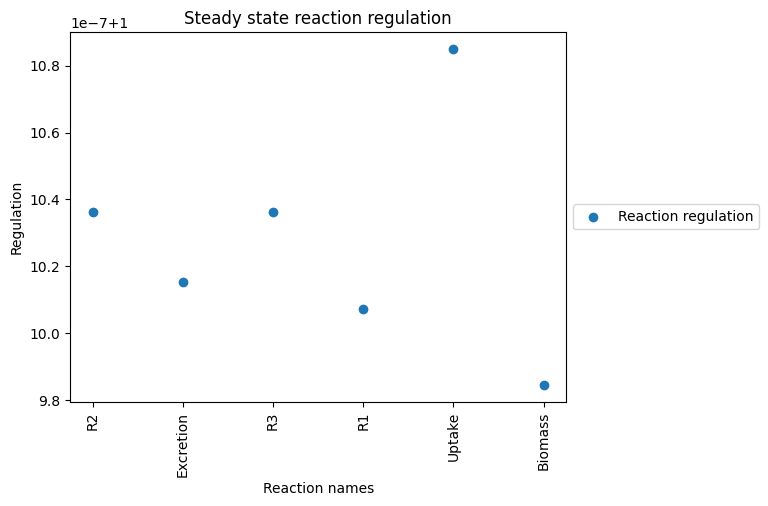

smallModel_B:CYTOSOL_1e-11_


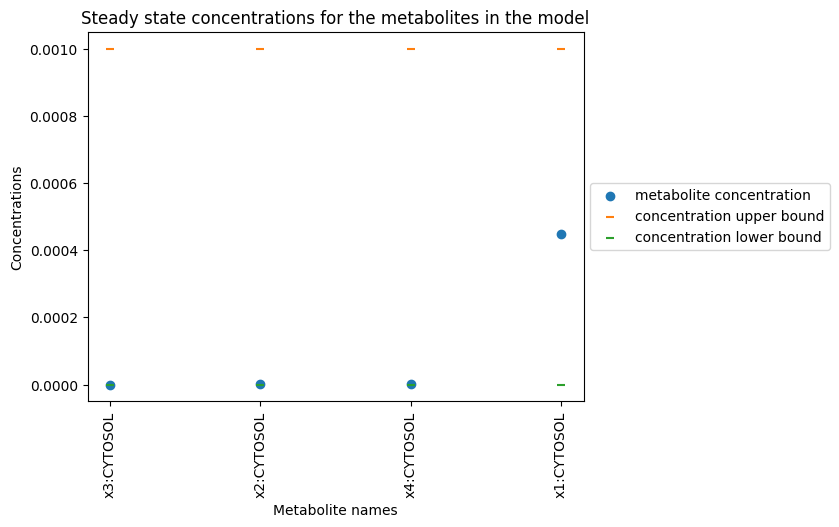

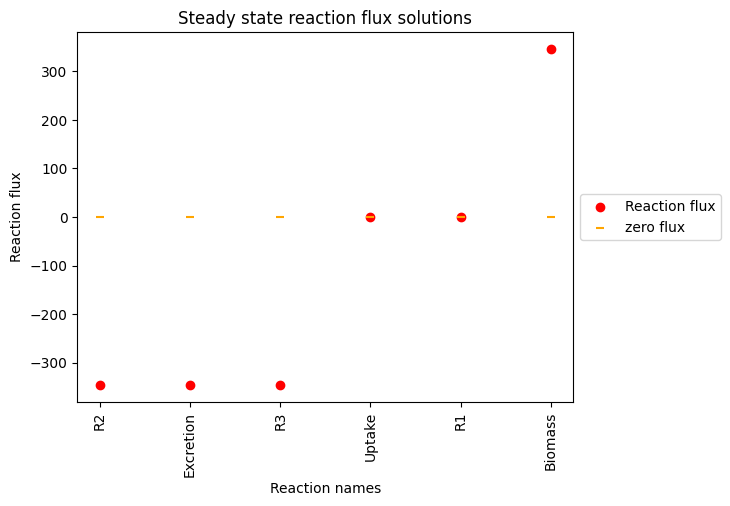

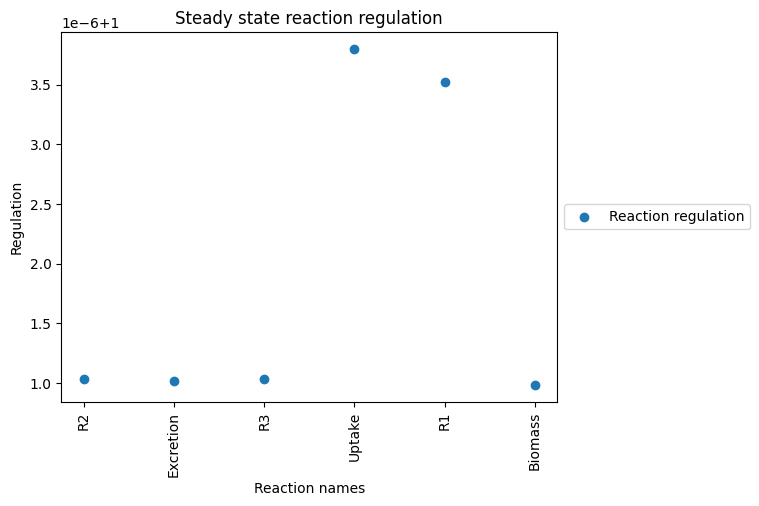

smallModel_B:CYTOSOL_1e-10_


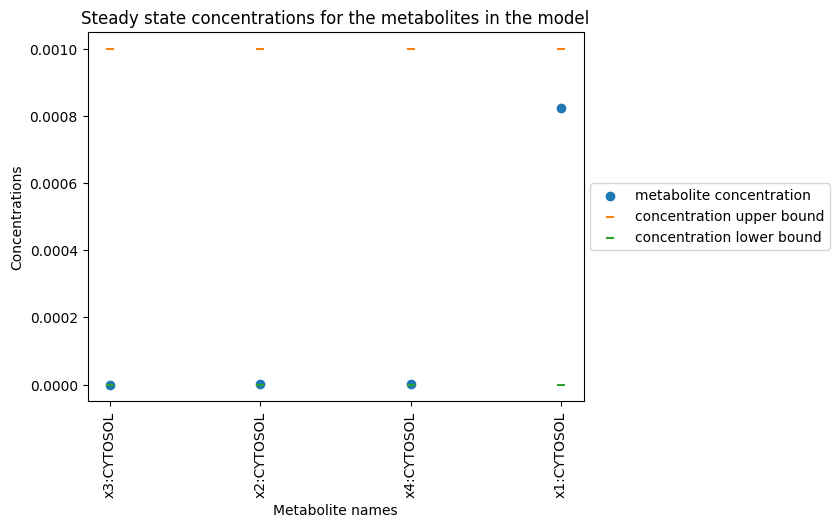

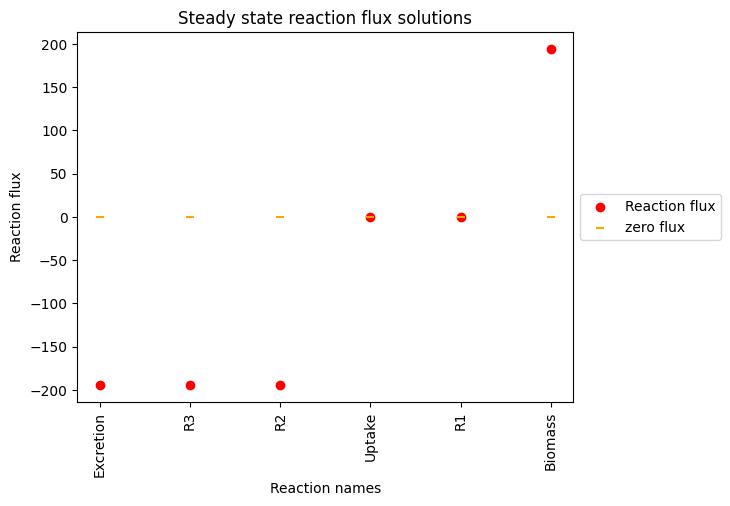

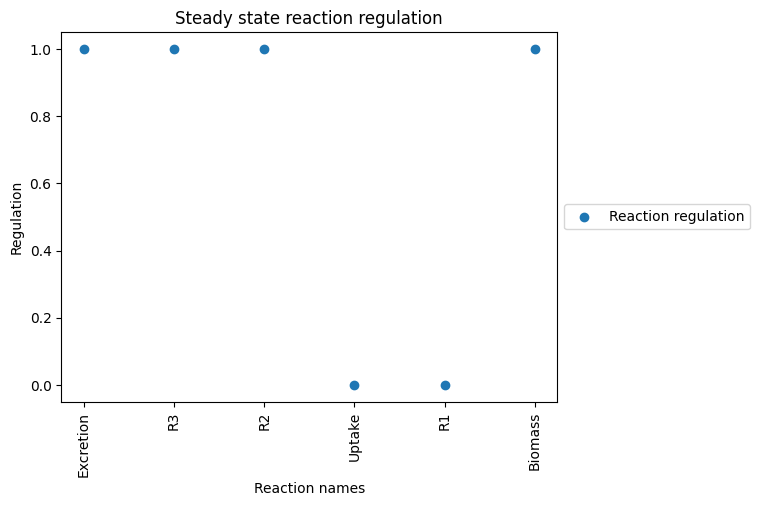

smallModel_B:CYTOSOL_1e-09_


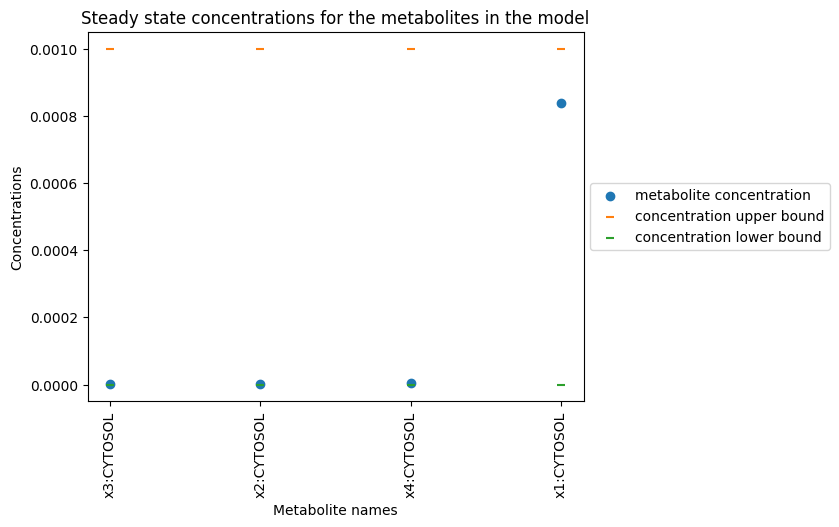

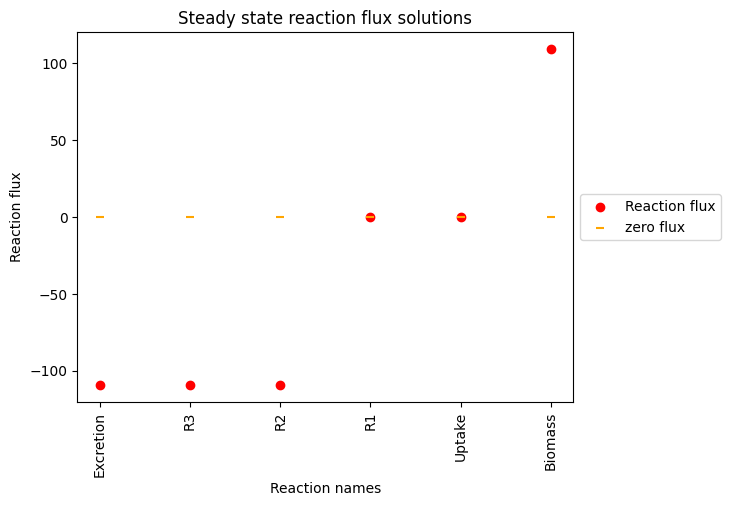

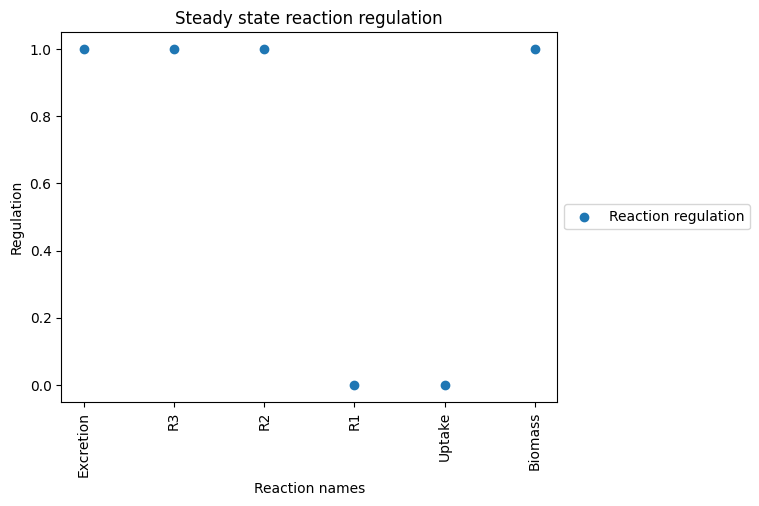

smallModel_B:CYTOSOL_1e-08_


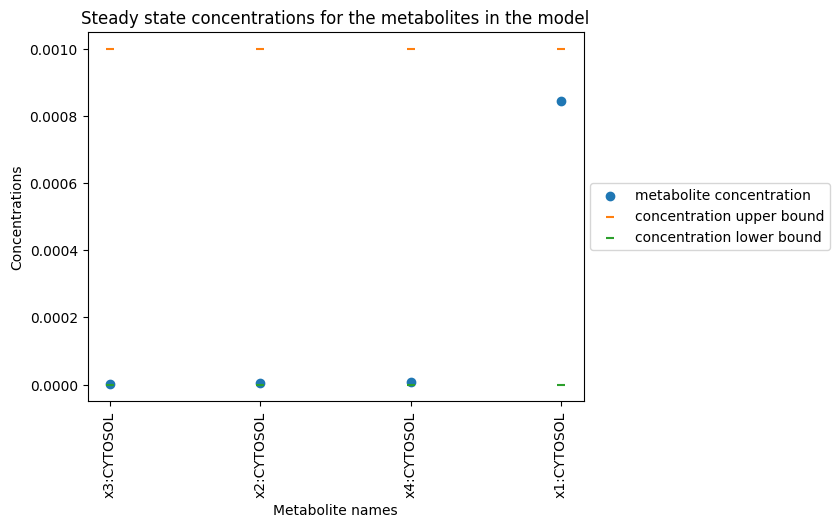

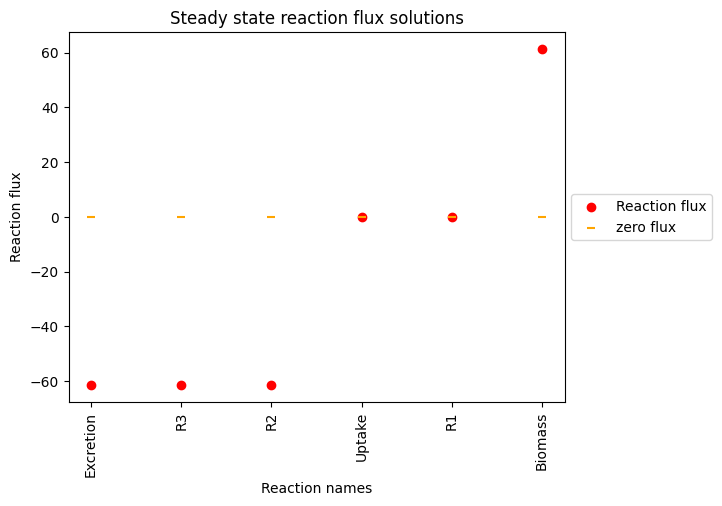

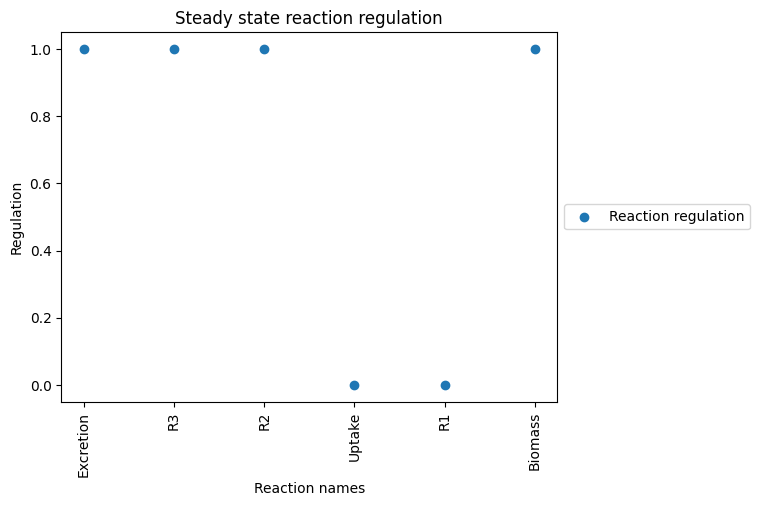

simulation: smallModel_B:CYTOSOL_1e-07_ not found
smallModel_B:CYTOSOL_1e-06_


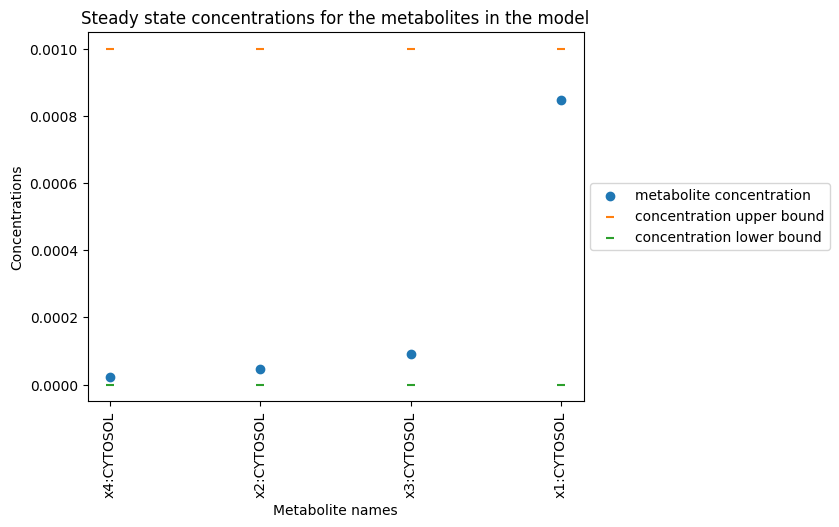

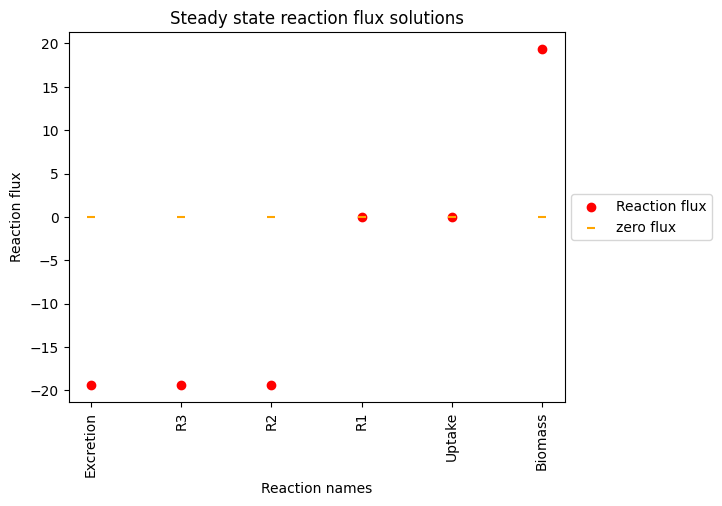

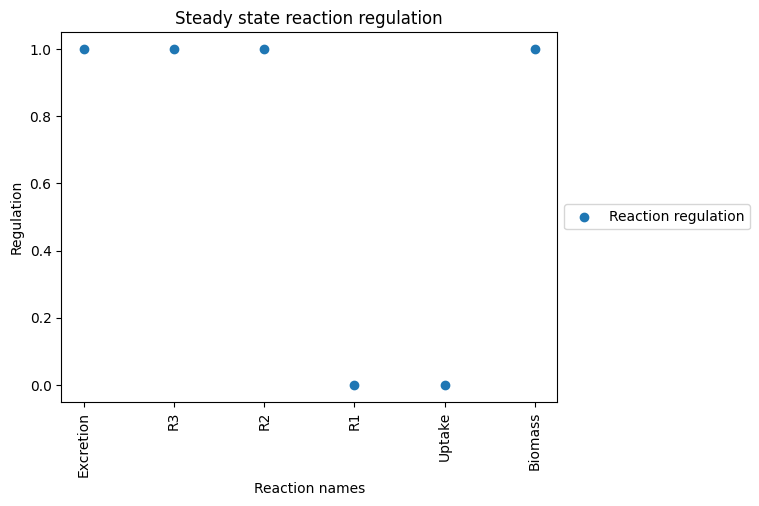

smallModel_B:CYTOSOL_1e-05_


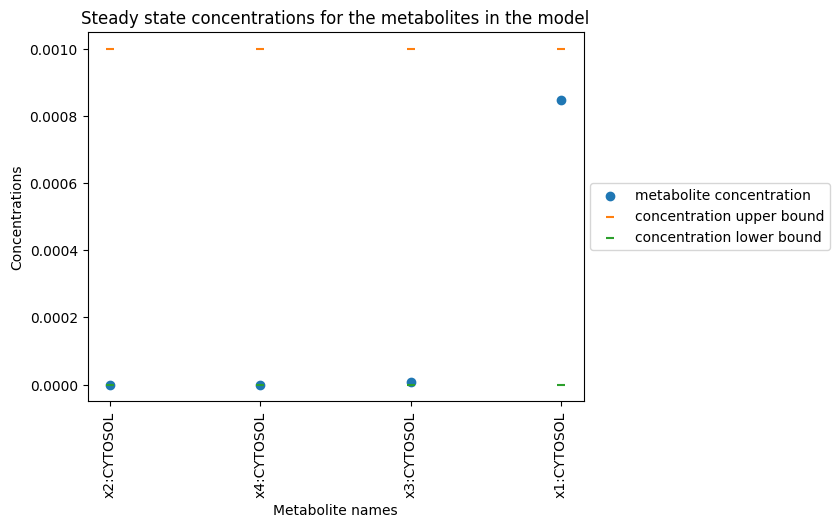

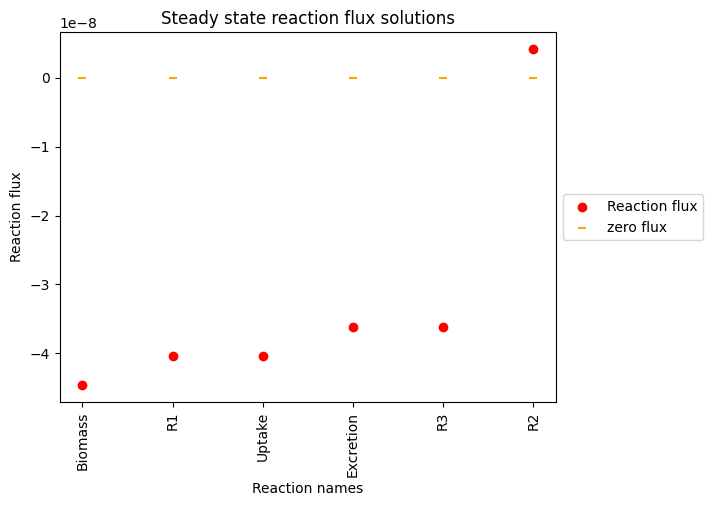

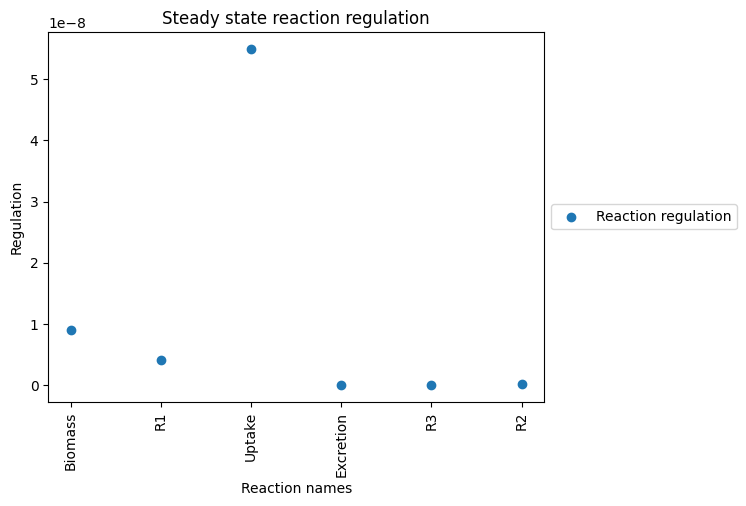

smallModel_B:CYTOSOL_0.0001_


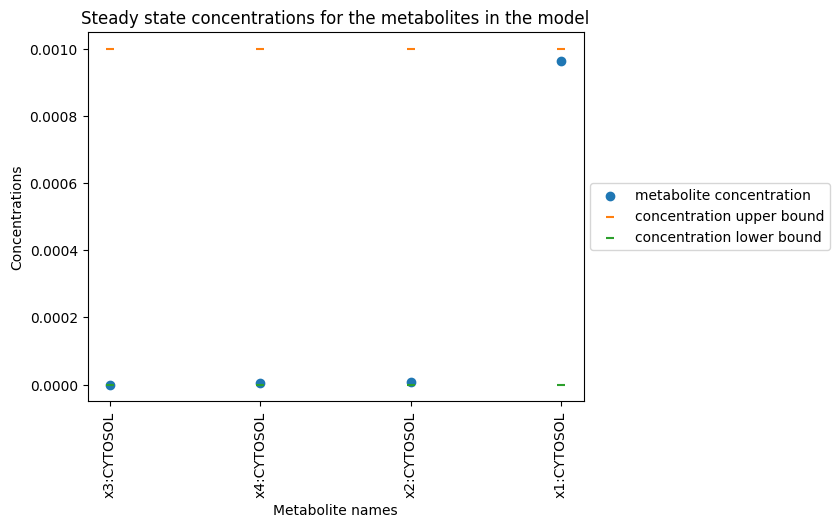

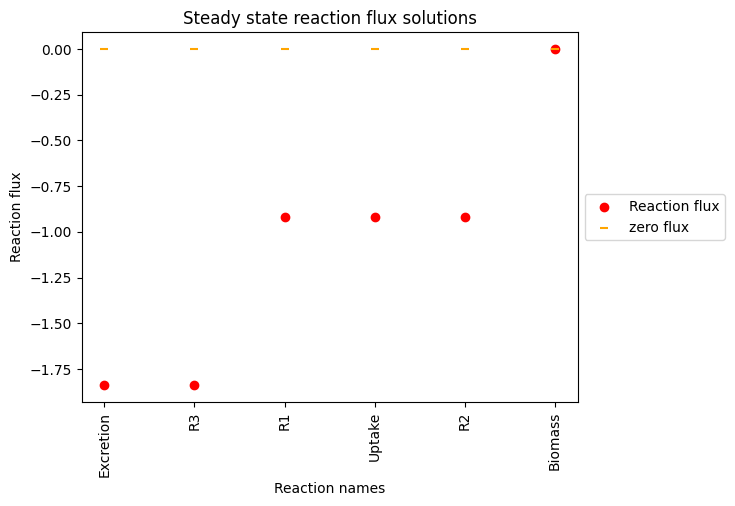

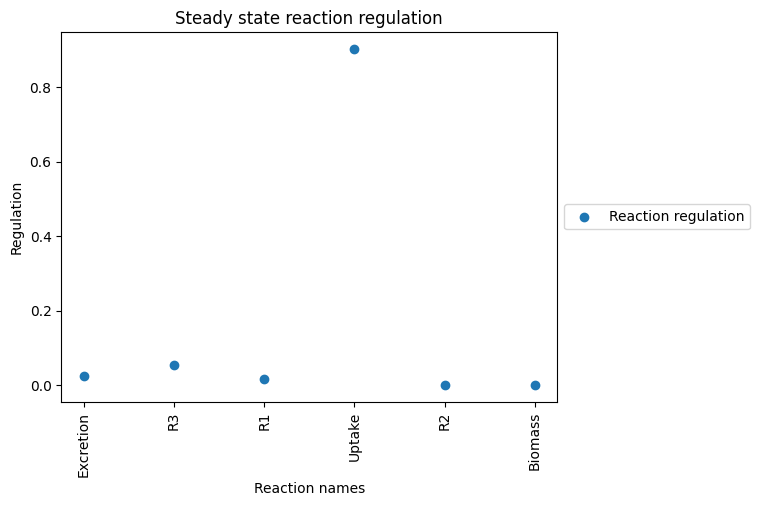

simulation: smallModel_B:CYTOSOL_0.001_ not found


IndexError: list index out of range

In [13]:
reload(anf)
reload(baf)
conditionVector=conditions
metaboliteSubset=['x1:CYTOSOL','x2:CYTOSOL','x3:CYTOSOL','x4:CYTOSOL']
reactionSubset=[]
concentrationdf =anf.PlotBestSimulations(bestSimulations,control_dictionary,metaboliteSubset,reactionSubset,conditionVector)

References:

    [1] "An approach to learn regulation to maximize growth and entropy production rates in metabolism", (2023), King, E. et al. Front. Syst. Biol., 3
    
    [2] "Acceleration Strategies to Enhance Metabolic Ensemble Modeling Performance", (2017), Greene, J. L. et al. Biophys J., 113